# Imports

In [4]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

import warnings
warnings.filterwarnings('ignore')

In [17]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from termcolor import colored

import keras
import tensorflow as tf

In [7]:
print(f'Keras Version : {keras.__version__}')
print(f'tensorflow Version : {tf.__version__}')

Keras Version : 3.2.1
tensorflow Version : 2.16.1


In [15]:
print(colored('Your hardware uses : ', 'blue', attrs=['bold']))
if len(tf.config.list_physical_devices('GPU')) == 0 :
    print(colored('CPU', 'green', attrs=['bold']))
else :
    print(colored('GPU ', 'green', attrs=['bold']))

Your hardware uses : 
GPU 


#  Load data

In [18]:
# locatoin of stored dataset
base_dir = '/home/nima/Datasets/Rice_Image_Dataset'

# loop over dataset folder to detect classes
classes = [class_name for class_name in os.listdir(base_dir) if class_name]

# remove .txt and .pdf file in classes and print it
classes.remove('Rice_Citation_Request.txt')
classes.remove('S0168169921003021.pdf')
print(classes)

['Ipsala', 'Jasmine', 'Basmati', 'Karacadag', 'Arborio']


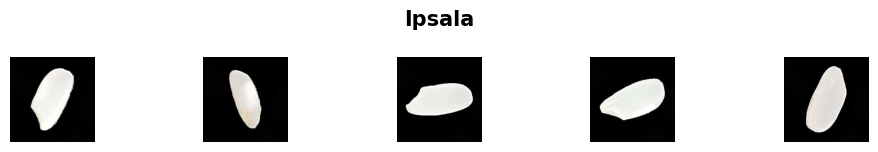

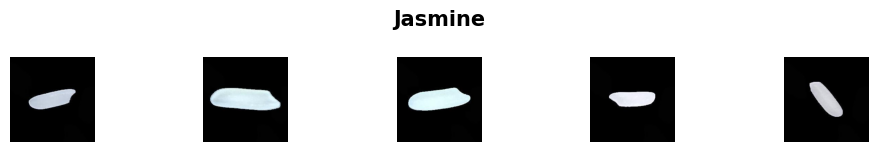

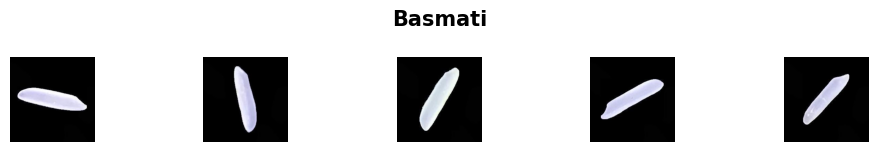

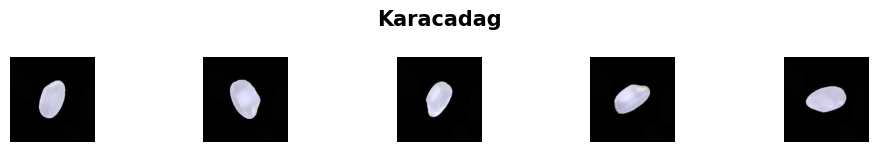

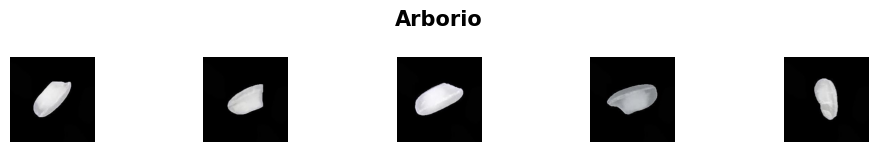

In [70]:
for class_name in classes :
    # print(class_name)
    class_path = os.path.join(base_dir, class_name)
    # print(class_path)
    images = os.listdir(class_path)
    random_images = random.choices(images, k=5)
    # print(random_images)
    fig, ax = plt.subplots(1, 5, figsize=(10, 1.5))
    for i in range(5) :
        plt.suptitle(class_name, fontsize=15, fontweight='bold')
        img = os.path.join(class_path, random_images[i])
        img = keras.utils.load_img(img)
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.tight_layout()

Number of all samples : 75000


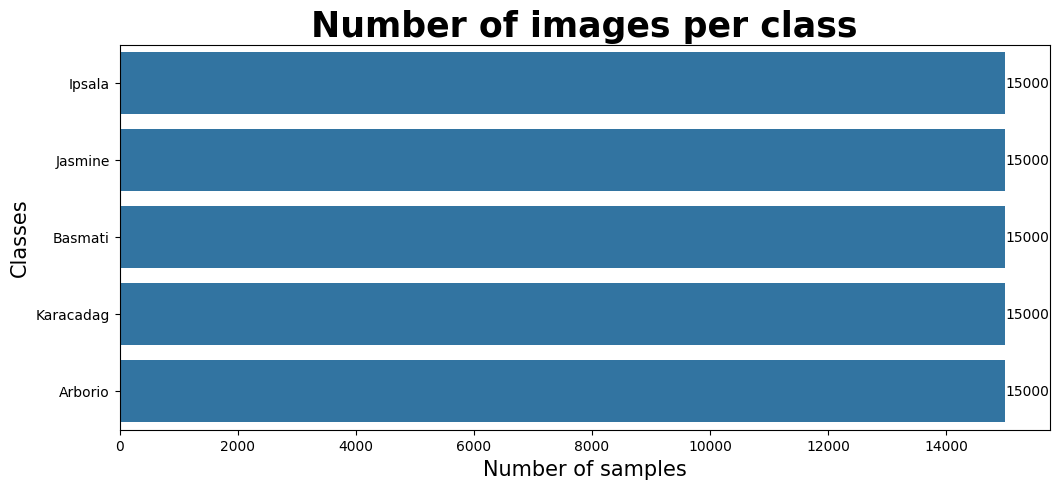

In [72]:
counts = []
for class_name in classes :

    class_path = os.path.join(base_dir, class_name)

    counts.append(len(os.listdir(class_path)))

print(colored(f'Number of all samples : {sum(counts)}', 'green', attrs=['bold']))


plt.figure(figsize=(12, 5))
ax = sns.barplot(y=classes, x=counts)
# Annotate each bar with the count
for i, p in enumerate(ax.patches):
    width = p.get_width()
    ax.text(width + 5, p.get_y() + p.get_height()/2., 
            '{}'.format(counts[i]),
            va="center", fontsize=10)
# Set plot title
plt.title('Number of images per class', fontsize=25, fontweight='bold')
# Set Y-axis label
plt.ylabel('Classes', fontsize=15)
# Set X-axis label
plt.xlabel('Number of samples', fontsize=15)
# Show plot
plt.show()

In [23]:
my_list = []
for class_name in classes :
    class_path = os.path.join(base_dir, class_name)
    files = os.listdir(class_path)
    for file in files :
        file_path = os.path.join(class_path, file)
        my_list.append((file_path, class_name))

df = pd.DataFrame(my_list, columns=['file_path', 'label'])

df = df.sample(frac=1).reset_index(drop=True)

df.head()

,file_path,label
0,/home/nima/Datasets/Rice_Image_Dataset/Basmati...,Basmati
1,/home/nima/Datasets/Rice_Image_Dataset/Jasmine...,Jasmine
2,/home/nima/Datasets/Rice_Image_Dataset/Ipsala/...,Ipsala
3,/home/nima/Datasets/Rice_Image_Dataset/Basmati...,Basmati
4,/home/nima/Datasets/Rice_Image_Dataset/Basmati...,Basmati


|Name|Pencentage of main DF|Number of samples|
|-----|-----|-----|
|Train|80%|60000|
|Validation|10%|7500|
|Test|10%|7500|

In [25]:
print(colored(f'Number of samples in DataFrame : {len(df)}', 'green', attrs=['bold']))

Number of samples in DataFrame : 75000


In [30]:
train_df = df[:60000]
valid_df = df[60000:67500]
test_df = df[67500:]

train_df.reset_index(inplace = True, drop = True)
test_df.reset_index(inplace = True, drop = True)
valid_df.reset_index(inplace = True, drop = True)

print(colored(f'Number of samples in train DataFrame : {len(train_df)}', 'green', attrs=['bold']))
print(colored(f'Number of samples in validation DataFrame : {len(valid_df)}', 'green', attrs=['bold']))
print(colored(f'Number of samples in test DataFrame : {len(test_df)}', 'green', attrs=['bold']))

Number of samples in train DataFrame : 60000
Number of samples in validation DataFrame : 7500
Number of samples in test DataFrame : 7500


In [31]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator
# Set the image size and batch size
image_size = (50, 50)
batch_size = 32

# Create an ImageDataGenerator object with data augmentation options for image preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Create a generator for the training data
train_generator = datagen.flow_from_dataframe(
    train_df,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Create a generator for the validation data
test_generator = datagen.flow_from_dataframe(
    valid_df,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Create a generator for the test data
test_generator = datagen.flow_from_dataframe(
    test_df,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 60000 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.
Found 7500 validated image filenames belonging to 5 classes.


In [33]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
# Set the input shape for the model
input_shape = (50, 50, 3)

# Create a Sequential model
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [69]:
model = Sequential()
# model.add(Input(shape=(224, 224, 3)))
model.add(Conv2D(32, 3, activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(2, 2))
model.add(keras.layers.BatchNormalization())
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(keras.layers.BatchNormalization())
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [67]:
# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [68]:
# Train the model on the training data
history = model.fit(train_generator,epochs=5,validation_data=test_generator)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 60s 29ms/step - accuracy: 0.7995 - loss: 0.5028 - val_accuracy: 0.7645 - val_loss: 0.6900
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 55s 29ms/step - accuracy: 0.9556 - loss: 0.1252 - val_accuracy: 0.8841 - val_loss: 0.3391
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 55s 29ms/step - accuracy: 0.9676 - loss: 0.0921 - val_accuracy: 0.9745 - val_loss: 0.0765
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 55s 29ms/step - accuracy: 0.9714 - loss: 0.0831 - val_accuracy: 0.8832 - val_loss: 0.3313
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 55s 29ms/step - accuracy: 0.9778 - loss: 0.0657 - val_accuracy: 0.9839 - val_loss: 0.0523


In [38]:
result_df = pd.DataFrame(history.history)
result_df

,accuracy,loss,val_accuracy,val_loss
0,0.844017,0.387582,0.936000,0.184212
1,0.933883,0.177546,0.948000,0.148538
2,0.951383,0.133388,0.966000,0.101689
3,0.962967,0.102761,0.923600,0.207647
4,0.968867,0.085039,0.980133,0.056660


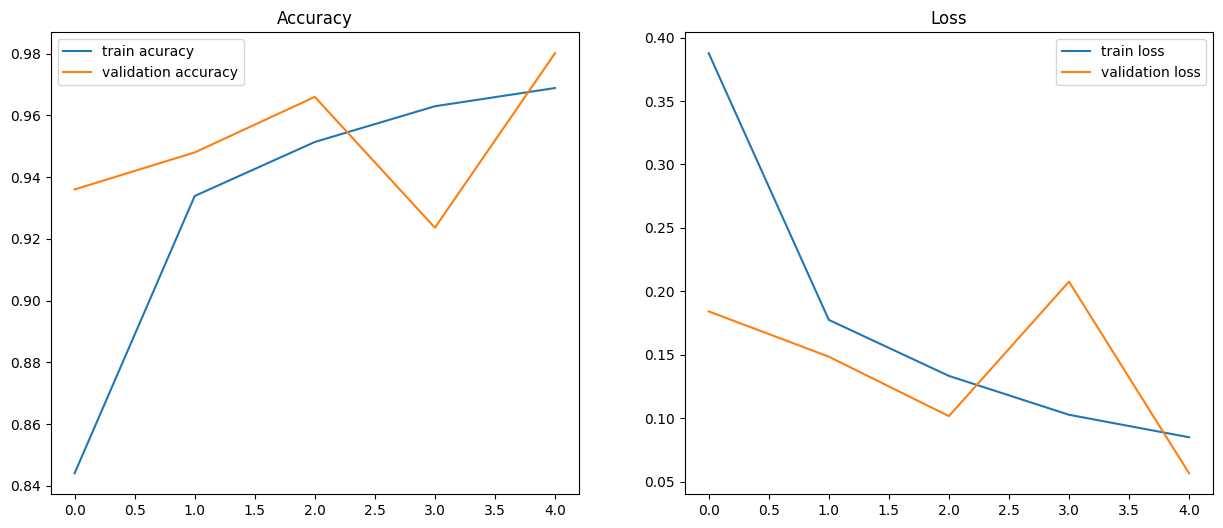

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(result_df.accuracy, label='train acuracy')
ax[0].plot(result_df.val_accuracy, label='validation accuracy')
ax[0].set_title('Accuracy')
ax[0].legend()

ax[1].plot(result_df.loss, label='train loss')
ax[1].plot(result_df.val_loss, label='validation loss')
ax[1].set_title('Loss')
ax[1].legend()

plt.show()

In [56]:
loss, acc = model.evaluate(test_generator)

print(colored(f'Loss : {round(loss, 4)}', 'green', attrs=['bold']))
print(colored(f'Accuracy : {round(acc, 4)}', 'green', attrs=['bold']))

235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9785 - loss: 0.0650
Loss : 0.0609
Accuracy : 0.9792
